# Imports

In [1]:
import os
import warnings

warnings.filterwarnings("ignore") 
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

# Set up Data

In [2]:
# Choose whether you want to train the model on stock prices of 1 company or 33 companies

# dataset = 'small_dataset'
dataset = 'big_dataset'


data = pd.read_csv(dataset+'.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.date = data.date.astype('datetime64')


In [3]:
# Append time index feature
data["time_idx"] = 0


if dataset == 'big_dataset':
    comp_list = ['AMZN', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'FB', 'TWTR', 'AMD','ADBE','ABNB','ALGN','AMAT','ADSK',
             'EA','HON','NFLX','TSLA','ZM','SPLK','SWKS','SBUX','SGEN','MRNA', 'MU','OKTA','ODFL','ORLY','PCAR',
             'PDD','PAYX','ROST','SIRI','TMUS']
else:
    comp_list = ['GOOG']

    
for ticker in comp_list:
   
    a,b,c,d,e = 0,1,2,3,4
    p_weekofyear = data.loc[data['ticker']== ticker]['date'].min().weekofyear
    for index, row in data.loc[data['ticker']== ticker].iterrows():
        
        c_weekofyear = row['date'].weekofyear
        if p_weekofyear != c_weekofyear:
            if c_weekofyear > p_weekofyear: 
                diff = c_weekofyear - p_weekofyear
            else:
                diff =52 - p_weekofyear +c_weekofyear
            p_weekofyear = c_weekofyear 
            a+= 5*diff
            b+= 5*diff
            c+= 5*diff
            d+= 5*diff
            e+= 5*diff

        if row['date'].day_name() == 'Monday':
            data.loc[index,'time_idx'] = a
        elif row['date'].day_name() == 'Tuesday':
            data.loc[index,'time_idx'] = b
        elif row['date'].day_name() == 'Wednesday':
            data.loc[index,'time_idx'] = c
        elif row['date'].day_name() == 'Thursday':
            data.loc[index,'time_idx'] = d
        elif row['date'].day_name() == 'Friday':
            data.loc[index,'time_idx'] = e

    

In [4]:
# Append additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  
data["weekofyear"] =  data.date.dt.weekofyear.astype(str).astype("category")
data['ticker'] = data['ticker'].astype('category')

In [5]:
## Construct dataloaders for training and testing

# maximum history length used by the time series dataset
max_encoder_length = 70
# maximum decoder length
max_prediction_length = 1
# Set the size of the training set
# 753 = test set size
training_cutoff = data["time_idx"].max() - 753


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff], # training data
    time_idx="time_idx",  # time index to identify the order of the elements in the time series
    target="Close", # target column
    group_ids=['ticker'], # list of column names identifying a time series.
    min_encoder_length=max_encoder_length,  # set min_encoder_length = max_encoder_length
    max_encoder_length=max_encoder_length, 
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['ticker'], # static covariates
    time_varying_known_categoricals=["weekofyear", "month"], # Known future inputs (categorical)
    time_varying_known_reals=["time_idx"], # Known future inputs (continuous)
    time_varying_unknown_reals=[  # Observed inputs
        "Open",
        "High",
        "Low",
        "Close",
        "^NDXT_Close",
        "QTEC_Close",
        "^SP500-45_Close",
    ],
	allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(
        groups=["ticker"], transformation="softplus"
    ),  

    add_target_scales=True, #  Add scales for target to static real features 
                            # (i.e. add the mean and svariance of the unnormalized
                            # timeseries as features)
)

# create validation dataset
# (predict=True) means to predict
# the last max_prediction_length points in the given time_series => Set to False
validation = TimeSeriesDataSet.from_dataset(training, data, predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 128 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size , num_workers=2) 

# Set up Model & Trainer

In [6]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1, # prevent divergance
                           # of the gradient for recurrent neural networks
    limit_train_batches=30,  # running valdiation every 30 batches
    callbacks=[ early_stop_callback],
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
    # reduce lr after 4 epochs if no improvement in performance
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 23.1k


# Train Model

In [7]:
# Set the seed to ensure reproducible results
pl.seed_everything(2022)

Global seed set to 2022


2022

In [8]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.2 K 
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 813   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Global seed set to 2022


Epoch 60: 100%|██████████| 804/804 [00:44<00:00, 17.93it/s, loss=5.49, v_num=9, train_loss_step=4.900, val_loss=14.90, train_loss_epoch=6.040]


# Test Model

In [9]:
# load the best model according to the validation loss
best_model_path =  trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [10]:
# Find out the actual and perdicted labels
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode= 'prediction')

In [11]:
# Store the time indices of the validation dataset
time_id = torch.cat([x['decoder_time_idx'] for x, y in iter(val_dataloader)])

In [12]:
# Fetch validation set
val_set = data.loc[data['ticker']== 'GOOG'].tail(753).copy()

In [13]:
# Figure out the time index of the first timestep in the validation set
pot_first_tidx = ((time_id  == val_set.iloc[0]['time_idx']).nonzero(as_tuple=True)[0]) 
fcond = actuals[pot_first_tidx] == (val_set.iloc[0]['Close'])
first_tidx = pot_first_tidx[fcond.squeeze()].item()

In [14]:
# Figure out the time index of the last timestep in the validation set
pot_last_tidx = ((time_id  == val_set.iloc[-1]['time_idx']).nonzero(as_tuple=True)[0])
lcond = actuals[pot_last_tidx] == (val_set.iloc[-1]['Close'])
last_tidx = pot_last_tidx[lcond.squeeze()].item()

# RMSE Results

In [19]:
steps = [10, 20, 30,50,70,len(actuals[first_tidx:last_tidx]) ]


for i in steps:
    rmse =  np.sqrt(((actuals[first_tidx:first_tidx+i]-predictions[first_tidx:first_tidx+i])**2).mean())
    print('RMSE loss for '+ str(i)+ ' forecasting steps: ', rmse.item() )
    # Save the rmse values in csv file
    with open('TFT'+".csv", "a") as rmse_file:
        rmse_file.write('look_back_window' + ", " +str(max_encoder_length)+ ", " + str(rmse)+"\n")

RMSE loss for 10 forecasting steps:  13.473105430603027
RMSE loss for 20 forecasting steps:  16.71624755859375
RMSE loss for 30 forecasting steps:  16.105693817138672
RMSE loss for 50 forecasting steps:  15.84580135345459
RMSE loss for 70 forecasting steps:  14.66705322265625
RMSE loss for 729 forecasting steps:  557.3442993164062


# Produce a Graph

In [16]:
# Create folder for graphs
folderName = "Graphs"
if not os.path.exists("Graphs"):
    os.makedirs(folderName)
    print("Graphs folder created!")

Graphs folder created!


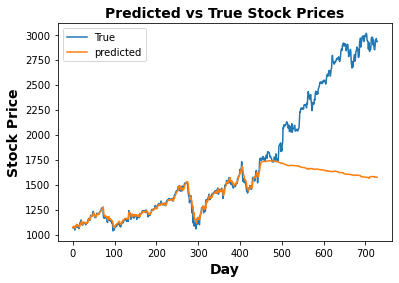

In [17]:
import matplotlib.pyplot as plt

plt.plot(actuals[first_tidx:last_tidx].numpy(), label = 'True')
plt.plot(predictions[first_tidx:last_tidx].numpy(), label = 'predicted')

plt.title('Predicted vs True Stock Prices',fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price',fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.savefig('Graphs/'+'look_back_window'+str(max_encoder_length)+'.png')
plt.show()